## Importing Required Libraries

In [16]:
import pandas as pd
import numpy as np
import json
import re
from typing import List, Dict, Any, Tuple
import faiss
from sentence_transformers import SentenceTransformer
from openai import OpenAI
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from dotenv import load_dotenv
import openai
import os
from langchain_community.utilities import GoogleSerperAPIWrapper



# ✅ Load environment variables
load_dotenv()
openai_api_key = os.getenv("OPEN_AI_KEY")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")



In [15]:
# pip install langchain_community

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached marshmallow-3.26.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 5.7 MB/s  0:00:00 eta 0:00:01
Using cached dataclasses_json-0.6.7-py3-none-any.whl (28 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.5 MB/s  0:00:00
Using cached marshmallow-3.26.1-py3-none-any.whl (50 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.6 MB/s  0:00:00 eta 0:00:01
Using cached typing_inspect-0.9.0-py3-none-any.whl (8.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/10 [langchain_community]ngchain_community]
Note: you may need to restart the kernel to use updated packages.


## Downloading the Dataset

In [2]:
## Data 1: reading the Comprehensive Medical Q&A Dataset
df_qa = pd.read_csv("medical_q_n_a.csv")
## Data has 16407 rows, hence we will sample 500 rows for experimentation
df_qa = df_qa.sample(500, random_state=0).reset_index(drop=True)
print(df_qa.shape)
df_qa.head()

(500, 3)


,qtype,Question,Answer
0,frequency,How many people are affected by X-linked chond...,The prevalence of X-linked chondrodysplasia pu...
1,treatment,What are the treatments for Kawasaki disease ?,These resources address the diagnosis or manag...
2,genetic changes,What are the genetic changes related to Ellis-...,Ellis-van Creveld syndrome can be caused by mu...
3,symptoms,What are the symptoms of Renal dysplasia-limb ...,What are the signs and symptoms of Renal dyspl...
4,information,What is (are) Fraser syndrome ?,Fraser syndrome is a rare disorder that affect...


In [3]:
# Preparing the Dataframe for Vector DB by combining the Text
df_qa['combined_text'] = (
    "Question: " + df_qa['Question'].astype(str) + ". " +
    "Answer: " + df_qa['Answer'].astype(str) + ". " +
    "Type: " + df_qa['qtype'].astype(str) + ". "
)

df_qa.head()

,qtype,Question,Answer,combined_text
0,frequency,How many people are affected by X-linked chond...,The prevalence of X-linked chondrodysplasia pu...,Question: How many people are affected by X-li...
1,treatment,What are the treatments for Kawasaki disease ?,These resources address the diagnosis or manag...,Question: What are the treatments for Kawasaki...
2,genetic changes,What are the genetic changes related to Ellis-...,Ellis-van Creveld syndrome can be caused by mu...,Question: What are the genetic changes related...
3,symptoms,What are the symptoms of Renal dysplasia-limb ...,What are the signs and symptoms of Renal dyspl...,Question: What are the symptoms of Renal dyspl...
4,information,What is (are) Fraser syndrome ?,Fraser syndrome is a rare disorder that affect...,Question: What is (are) Fraser syndrome ?. Ans...


In [4]:
## Data 2: reading the Medical Device Manuals Dataset
df_medical_device = pd.read_csv("medical_device_manuals_dataset.csv")
print(df_medical_device.shape)
## Data has 2694 rows, hence we will sample 500 rows for experimentation
df_medical_device = df_medical_device.sample(500, random_state=0).reset_index(drop=True)
print(df_medical_device.shape)
df_medical_device.head()

(2694, 16)
(500, 16)


,Device_Name,Model_Number,Manufacturer,Manual_Version,Publication_Date,Device_Class,Regulatory_Approval_ID,Patient_Population,Indications_for_Use,Contraindications,Sterilization_Method,Number_of_Warnings,Number_of_Cautions,Device_Lifetime_Years,Device_Weight_kg,Max_Operating_Temperature_C
0,Electrosurgical Unit,Model 1606,Zimmer Biomet,2023-04-Z,2018-04-28,Class IIb,MDR-847127,All,Used for thermal therapy guidance in oncology ...,Contraindicated in presence of radio frequenci...,Hydrogen Peroxide Plasma,10,15,15.0,6.71,27.0
1,Dialysis Machine,X-6538,3M Healthcare,v2.8,2018-04-03,Class I,MDR-416480,Adult (>65),Used for post-operative chemotherapy managemen...,NaN,Gamma Irradiation,8,11,11.0,NaN,17.0
2,Ventilator,SON230,Sonova,Version 13,2022-02-24,Class III,BLA670706,Adult (>65),Indicated for real-time temperature assessment...,Do not use during general anesthesia administr...,Pre-Sterilized,18,28,11.0,149.42,25.0
3,Dialysis Machine,Max787,Boston Scientific,v4.7,2016-05-08,Class II,BLA131698,Neonatal,Intended for sterilization guidance during min...,"Not recommended during pregnancy, lactation, o...",NaN,10,15,15.0,20.96,20.0
4,Electrosurgical Unit,Plus691,Abbott,2020-03-Q,2015-01-30,Class III,H127393,Pediatric,Intended for life support evaluation in rehabi...,Contraindicated in patients with severe diabet...,Single-Use Sterile,13,17,8.0,7.75,31.0


In [5]:
# Preparing the Dataframe for Vector DB by combining the Text
df_medical_device['combined_text'] = (
    "Device Name: " + df_medical_device['Device_Name'].astype(str) + ". " +
    "Model: " + df_medical_device['Model_Number'].astype(str) + ". " +
    "Manufacturer: " + df_medical_device['Manufacturer'].astype(str) + ". " +
    "Indications: " + df_medical_device['Indications_for_Use'].astype(str) + ". " +
    "Contraindications: " + df_medical_device['Contraindications'].fillna('None').astype(str)
)
df_medical_device.head()

,Device_Name,Model_Number,Manufacturer,Manual_Version,Publication_Date,Device_Class,Regulatory_Approval_ID,Patient_Population,Indications_for_Use,Contraindications,Sterilization_Method,Number_of_Warnings,Number_of_Cautions,Device_Lifetime_Years,Device_Weight_kg,Max_Operating_Temperature_C,combined_text
0,Electrosurgical Unit,Model 1606,Zimmer Biomet,2023-04-Z,2018-04-28,Class IIb,MDR-847127,All,Used for thermal therapy guidance in oncology ...,Contraindicated in presence of radio frequenci...,Hydrogen Peroxide Plasma,10,15,15.0,6.71,27.0,Device Name: Electrosurgical Unit. Model: Mode...
1,Dialysis Machine,X-6538,3M Healthcare,v2.8,2018-04-03,Class I,MDR-416480,Adult (>65),Used for post-operative chemotherapy managemen...,NaN,Gamma Irradiation,8,11,11.0,NaN,17.0,Device Name: Dialysis Machine. Model: X-6538. ...
2,Ventilator,SON230,Sonova,Version 13,2022-02-24,Class III,BLA670706,Adult (>65),Indicated for real-time temperature assessment...,Do not use during general anesthesia administr...,Pre-Sterilized,18,28,11.0,149.42,25.0,Device Name: Ventilator. Model: SON230. Manufa...
3,Dialysis Machine,Max787,Boston Scientific,v4.7,2016-05-08,Class II,BLA131698,Neonatal,Intended for sterilization guidance during min...,"Not recommended during pregnancy, lactation, o...",NaN,10,15,15.0,20.96,20.0,Device Name: Dialysis Machine. Model: Max787. ...
4,Electrosurgical Unit,Plus691,Abbott,2020-03-Q,2015-01-30,Class III,H127393,Pediatric,Intended for life support evaluation in rehabi...,Contraindicated in patients with severe diabet...,Single-Use Sterile,13,17,8.0,7.75,31.0,Device Name: Electrosurgical Unit. Model: Plus...


## Setting up Vector Store (ChromaDB)

### Creating the Chroma DB client 

In [6]:
import chromadb
# Setting up the Chromadb
client = chromadb.PersistentClient(path="./chroma_db")

### Creating the Collections

We will create two collections, one for Q&A Dataset and one for device manual dataset

In [ ]:
# Collection 1 for medical Q&A Dataset
collection1 = client.get_or_create_collection(name="medical_q_n_a")

In [8]:
# Add data to collection
# here the chroma db will use default embeddings (sentence transformers)
collection1.add(
    documents=df_qa['combined_text'].tolist(),
    metadatas=df_qa.to_dict(orient="records"),
    ids=df_qa.index.astype(str).tolist(),
)




In [221]:
# quick check
query = "What are the treatments for Kawasaki disease ?"

results = collection1.query(query_texts=[query],
    n_results=3
)
print(results)

{'ids': [['1', '393', '60']], 'embeddings': None, 'documents': [["Question: What are the treatments for Kawasaki disease ?. Answer: These resources address the diagnosis or management of Kawasaki disease:  - Cincinnati Children's Hospital Medical Center  - Genetic Testing Registry: Acute febrile mucocutaneous lymph node syndrome  - National Heart, Lung, and Blood Institute: How is Kawasaki Disease Treated?   These resources from MedlinePlus offer information about the diagnosis and management of various health conditions:  - Diagnostic Tests  - Drug Therapy  - Surgery and Rehabilitation  - Genetic Counseling   - Palliative Care. Type: treatment. ", 'Question: What are the treatments for Krabbe Disease ?. Answer: There is no cure for Krabbe disease. Results of a very small clinical trial of children with infantile Krabbe disease found that children who received umbilical cord blood stem cells from unrelated donors prior to symptom onset developed with little neurological impairment. Bon

In [165]:
client.delete_collection(name="medical_device_manual")
collection2 = client.get_or_create_collection(name="medical_device_manual")

In [166]:
# Add data to collection
# here the chroma db will use default embeddings (sentence transformers)
collection2.add(
    documents=df_medical_device['combined_text'].tolist(),
    metadatas=df_medical_device.to_dict(orient="records"),
    ids=df_medical_device.index.astype(str).tolist(),
)

In [222]:
# quick check
query = "Which devices are suitable for neonatal patients?"

results = collection2.query(query_texts=[query],
    n_results=5
)
print(results)

{'ids': [['218', '149', '235', '67', '174']], 'embeddings': None, 'documents': [['Device Name: Pacemaker. Model: JOH663. Manufacturer: Johnson & Johnson. Indications: Designed for catheterization support in neonatal intensive care environments.. Contraindications: Avoid use in patients with cardiac devices or cochlear implants. Not suitable for chemical exposure areas.', 'Device Name: Infusion Pump. Model: Model 7800. Manufacturer: Intuitive Surgical. Indications: Designed for joint replacement support in neonatal intensive care environments.. Contraindications: Not recommended for use in geriatric patients or those with hepatic dysfunction.', 'Device Name: Anesthesia Machine. Model: STR623. Manufacturer: Stryker. Indications: Designed for tissue biopsy support in neonatal intensive care environments.. Contraindications: Do not use in combination with sedatives or oxygen therapy modalities.', 'Device Name: Orthopedic Implant. Model: PHI214. Manufacturer: Philips Healthcare. Indications

In [223]:
collection2.query(query_texts=[query],
    n_results=3
)

{'ids': [['218', '149', '235']],
 'embeddings': None,
 'documents': [['Device Name: Pacemaker. Model: JOH663. Manufacturer: Johnson & Johnson. Indications: Designed for catheterization support in neonatal intensive care environments.. Contraindications: Avoid use in patients with cardiac devices or cochlear implants. Not suitable for chemical exposure areas.',
   'Device Name: Infusion Pump. Model: Model 7800. Manufacturer: Intuitive Surgical. Indications: Designed for joint replacement support in neonatal intensive care environments.. Contraindications: Not recommended for use in geriatric patients or those with hepatic dysfunction.',
   'Device Name: Anesthesia Machine. Model: STR623. Manufacturer: Stryker. Indications: Designed for tissue biopsy support in neonatal intensive care environments.. Contraindications: Do not use in combination with sedatives or oxygen therapy modalities.']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas':

## Setting up WebSearch API

In [ ]:
search = GoogleSerperAPIWrapper()

# testing the google search API
search.run(query="What are the various vaccines of COVID-19")

"Different types of COVID-19 vaccines: How they work · mRNA vaccine · mRNA vaccine · Messenger RNA (mRNA) vaccine · Viral vector vaccine · Viral vector vaccine ... First introduced in December 2020, the original COVID mRNA vaccines from both Pfizer and Moderna protected against the original SARS-CoV-2 virus ... Currently, there are two types of COVID-19 vaccines for use in the United States: mRNA, and protein subunit vaccines. None of these vaccines can ... On this page, you will find infographics to explain how different types of vaccines work, including the Pfizer/BioNTech vaccine, the Moderna vaccine and the ... Types of COVID-19 vaccines. Two types of COVID-19 vaccines are recommended for use in the United States: mRNA vaccines. Moderna COVID-19 Vaccine ... List of COVID-19 vaccine authorizations · Contents · Overview maps · Oxford–AstraZeneca · Pfizer–BioNTech · Janssen · Moderna · Sinopharm BIBP · Sputnik V. WHO recommends a simplified single-dose regime for primary immunization 

## Setting up the Open AI Client

In [168]:
from langchain_core.tools import tool

In [169]:
from openai import OpenAI


def get_llm_response(prompt: str) -> str:
    """Function to get response from LLM"""
    from openai import OpenAI
    client_llm = OpenAI(api_key=openai_api_key)
    response = client_llm.chat.completions.create(
        model="gpt-5-nano",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

## testing the LLM response
prompt = "Explain the theory of relativity in simple terms in 30 words"
response = get_llm_response(prompt)

print(response)

Relativity says physics laws work for observers, with no preferred frame, and nothing travels faster than light. Time and space bend with motion and gravity, equating mass and energy fundamentally.


## Part A: Traditional RAG

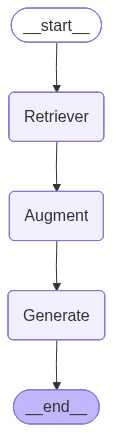

In [226]:
from typing import Literal
from langgraph.graph import StateGraph,MessagesState, START, END
from openai import OpenAI
from typing_extensions import TypedDict
from typing import List

# === Define workflow node functions ===
def retrieve_context(state):
    """Retrieve top documents from ChromaDB based on query."""
    print("---RETRIEVING CONTEXT---")
    query = state["query"] # last user message

    results = collection1.query(query_texts=[query], n_results=3)
    context = "\n".join(results["documents"][0])

    #state["query"] = query
    state["context"] = context
    print(context)
    # Save context in the state for later nodes
    return state

def build_prompt(state):
    """Construct the RAG-style prompt."""
    print("---AUGMENT (BUILDING PROMPT)---")
    query = state["query"]
    context = state["context"]

    prompt = f"""
            Answer the following question using the context below.

            Context:
            {context}

            Question: {query}

            please limit your answer in 50 words.
            """
    
    state["prompt"] = prompt
    print(prompt)
    return state

def call_llm(state):
    """Call your existing LLM function."""
    print("---GENERATE (CALLING LLM)---")
    prompt = state["prompt"]
    answer = get_llm_response(prompt)
    state["response"] = answer
    return state

# === Build the workflow ===

## Define the state structure
class GraphState(TypedDict):
    query : str
    prompt : str
    context : List[str]
    response : str

    
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("Retriever", retrieve_context)
workflow.add_node("Augment", build_prompt)
workflow.add_node("Generate", call_llm)

# Define edges
workflow.add_edge(START, "Retriever")
workflow.add_edge("Retriever", "Augment")
workflow.add_edge("Augment", "Generate")
workflow.add_edge("Generate", END)

# Compile agent
rag_agent = workflow.compile()

# === Run it ===
from IPython.display import Image, display
display(Image(rag_agent.get_graph().draw_mermaid_png()))

In [227]:
input_state = {"query": "What are the treatments for Kawasaki disease ?"}

from pprint import pprint
for step in rag_agent.stream(input_state):
    for key, value in step.items():
        pprint(f"Finished running: {key}:")
pprint(value["response"])

---RETRIEVING CONTEXT---
Question: What are the treatments for Kawasaki disease ?. Answer: These resources address the diagnosis or management of Kawasaki disease:  - Cincinnati Children's Hospital Medical Center  - Genetic Testing Registry: Acute febrile mucocutaneous lymph node syndrome  - National Heart, Lung, and Blood Institute: How is Kawasaki Disease Treated?   These resources from MedlinePlus offer information about the diagnosis and management of various health conditions:  - Diagnostic Tests  - Drug Therapy  - Surgery and Rehabilitation  - Genetic Counseling   - Palliative Care. Type: treatment. 
Question: What are the treatments for Krabbe Disease ?. Answer: There is no cure for Krabbe disease. Results of a very small clinical trial of children with infantile Krabbe disease found that children who received umbilical cord blood stem cells from unrelated donors prior to symptom onset developed with little neurological impairment. Bone marrow transplantation may help some peopl

## Part B: Agentic RAG

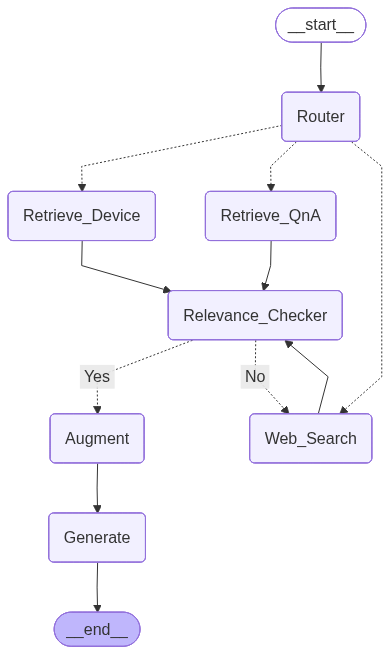

In [230]:
from typing import Literal
from langgraph.graph import StateGraph,MessagesState, START, END
from openai import OpenAI
from typing_extensions import TypedDict
from typing import List


# === Define workflow node functions ===
def retrieve_context_q_n_a(state):
    """Retrieve top documents from ChromaDB Collection 1 (Medical Q&A Data) based on query."""
    print("---RETRIEVING CONTEXT---")
    query = state["query"] # last user message

    results = collection1.query(query_texts=[query], n_results=3)
    context = "\n".join(results["documents"][0])
    state["context"] = context
    state["source"] = "Medical Q&A Collection"
    print(context)
    # Save context in the state for later nodes
    return state

# === Define workflow node functions ===
def retrieve_context_medical_device(state):
    """Retrieve top documents from ChromaDB Collection 2 (Medical Device Manuals Data) based on query."""
    print("---RETRIEVING CONTEXT---")
    query = state["query"] # last user message

    results = collection2.query(query_texts=[query], n_results=3)
    context = "\n".join(results["documents"][0])
    state["context"] = context
    state["source"] = "Medical Device Manual"
    print(context)
    # Save context in the state for later nodes
    return state

def web_search(state):
    """Perform web search using Google Serper API."""
    print("---PERFORMING WEB SEARCH---")
    query = state["query"]
    search_results = search.run(query=query)
    state["context"] = search_results
    state["source"] = "Web Search"
    print(search_results)
    return state

def router(state: GraphState) -> Literal[
    "Retrieve_QnA", "Retrieve_Device", "Web_Search"
]:
    """Agentic router: decides which retrieval method to use."""
    query = state["query"]

    # A lightweight decision LLM — you can replace this with GPT-4o-mini, etc.
    decision_prompt = f"""
    You are a routing agent. Based on the user query, decide where to look for information.

    Options:
    - Retrieve_QnA: if it's about general medical knowledge, symptoms, or treatment.
    - Retrieve_Device: if it's about medical devices, manuals, or instructions.
    - Web_Search: if it's about recent news, brand names, or external data.

    Query: "{query}"

    Respond ONLY with one of: Retrieve_QnA, Retrieve_Device, Web_Search
    """

    router_decision = get_llm_response(decision_prompt).strip()
    print(f"---ROUTER DECISION: {router_decision}---")

    print(router_decision)

    state["source"] = router_decision
    return state

# Define the routing function for the conditional edge
def route_decision(state: GraphState) -> str:
    return state["source"]


def build_prompt(state):
    """Construct the RAG-style prompt."""
    print("---AUGMENT (BUILDING GENERATIVE PROMPT)---")
    query = state["query"]
    context = state["context"]

    prompt = f"""
            Answer the following question using the context below.
            Context:
            {context}
            Question: {query}
            please limit your answer in 50 words.
            """
    
    state["prompt"] = prompt
    print(prompt)
    return state




def call_llm(state):
    """Call your existing LLM function."""
    print("---GENERATE (CALLING LLM)---")
    prompt = state["prompt"]
    answer = get_llm_response(prompt)
    state["response"] = answer
    return state


def check_context_relevance(state):
    """Determine whether to retrieved context is relevant or not."""
    print("---CONTEXT RELEVANCE CHECKER---")
    query = state["query"]
    context = state["context"]

    relevance_prompt = f"""
            Check the below context if the context is relevent to the user query or.
            ####
            Context:
            {context}
            ####
            User Query: {query}

            Options:
            - Yes: if the context is relevant.
            - No: if the context is not relevant.

            Please answer with only 'Yes' or 'No'.

            """
    relevance_decision_value = get_llm_response(relevance_prompt).strip()
    print(f"---RELEVANCE DECISION: {relevance_decision_value}---")
    state["is_relevant"] = relevance_decision_value
    return state

# Define the check_context_relevance function for the conditional edge
def relevance_decision(state: GraphState) -> str:
    iteration_count = state.get("iteration_count", 0)
    iteration_count += 1
    state["iteration_count"] = iteration_count
    ## Limiting to max 3 iterations
    if iteration_count >= 3:
        print("---MAX ITERATIONS REACHED, FORCING 'Yes'---")
        state["is_relevant"] = "Yes"
    return state["is_relevant"]





# === Build the workflow ===
## Define the state structure

class GraphState(TypedDict):
    query: str
    context: str
    prompt: str
    response: str
    source: str  # Which retriever/tool was used
    is_relevant: str
    iteration_count: int

    
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("Router", router)
workflow.add_node("Retrieve_QnA", retrieve_context_q_n_a)
workflow.add_node("Retrieve_Device", retrieve_context_medical_device)
workflow.add_node("Web_Search", web_search)
workflow.add_node("Relevance_Checker", check_context_relevance)
workflow.add_node("Augment", build_prompt)
workflow.add_node("Generate", call_llm)

# Define edges
workflow.add_edge(START, "Router")
workflow.add_conditional_edges(
    "Router",
    route_decision,  # this function decides the path dynamically
    {
        "Retrieve_QnA": "Retrieve_QnA",
        "Retrieve_Device": "Retrieve_Device",
        "Web_Search": "Web_Search",
    }
)
workflow.add_edge("Retrieve_QnA", "Relevance_Checker")
workflow.add_edge("Retrieve_Device", "Relevance_Checker")
workflow.add_edge("Web_Search", "Relevance_Checker")
workflow.add_conditional_edges(
    "Relevance_Checker",
    relevance_decision,  # this function decides the path dynamically
    {
        "Yes": "Augment",
        "No": "Web_Search",
    }
)
workflow.add_edge("Augment", "Generate")
workflow.add_edge("Generate", END)


# Compile the dynamic RAG agent
agentic_rag = workflow.compile()


# ===================================
# ===  Visualize Workflow (Optional) ===
# ===================================


# === Run it ===
from IPython.display import Image, display
display(Image(agentic_rag.get_graph().draw_mermaid_png()))

In [231]:
input_state = {"query": "What are the treatments for Kawasaki disease ?"}

from pprint import pprint
for step in agentic_rag.stream(input_state):
    for key, value in step.items():
        pprint(f"Finished running: {key}:")
pprint(value["response"])

---ROUTER DECISION: Retrieve_QnA---
Retrieve_QnA
'Finished running: Router:'
---RETRIEVING CONTEXT---
Question: What are the treatments for Kawasaki disease ?. Answer: These resources address the diagnosis or management of Kawasaki disease:  - Cincinnati Children's Hospital Medical Center  - Genetic Testing Registry: Acute febrile mucocutaneous lymph node syndrome  - National Heart, Lung, and Blood Institute: How is Kawasaki Disease Treated?   These resources from MedlinePlus offer information about the diagnosis and management of various health conditions:  - Diagnostic Tests  - Drug Therapy  - Surgery and Rehabilitation  - Genetic Counseling   - Palliative Care. Type: treatment. 
Question: What are the treatments for Krabbe Disease ?. Answer: There is no cure for Krabbe disease. Results of a very small clinical trial of children with infantile Krabbe disease found that children who received umbilical cord blood stem cells from unrelated donors prior to symptom onset developed with li

In [232]:
input_state = {"query": "What are the usage of Dialysis Machine Device?"}

from pprint import pprint
for step in agentic_rag.stream(input_state):
    for key, value in step.items():
        pprint(f"Finished running: {key}:")
pprint(value["response"])

---ROUTER DECISION: Retrieve_Device---
Retrieve_Device
'Finished running: Router:'
---RETRIEVING CONTEXT---
Device Name: Dialysis Machine. Model: Model 1703. Manufacturer: Edwards Lifesciences. Indications: Used for intraoperative measurement monitoring during complex oncological surgeries.. Contraindications: Not recommended in presence of peripheral vascular disease or at open wounds locations.
Device Name: Dialysis Machine. Model: Plus593. Manufacturer: Siemens Healthineers. Indications: Used for emergency tissue biopsy in acute diabetes situations requiring immediate care.. Contraindications: None
Device Name: Dialysis Machine. Model: Max384. Manufacturer: BioMérieux. Indications: Designed for continuous monitoring assistance in geriatric care facilities for elderly patients.. Contraindications: Avoid use if patient has cardiomyopathy or is receiving radioactive materials.
'Finished running: Retrieve_Device:'
---CONTEXT RELEVANCE CHECKER---
---RELEVANCE DECISION: Yes---
'Finished r

In [160]:
input_state = {"query": "What's the export duty on medical tablets on India by USA in 2025?"}

from pprint import pprint
for step in agentic_rag.stream(input_state):
    for key, value in step.items():
        pprint(f"Finished running: {key}:")
pprint(value["response"])

---ROUTER DECISION: Web_Search---
Web_Search
'Finished running: Router:'
---PERFORMING WEB SEARCH---
Here's a detailed analysis of what a 100% tariff on medicines exported from India to the U.S. might imply — both for the Indian pharma sector ... DGCI&S statistics reveal India's pharmaceutical formulation exports to the US reached $9.8 billion in FY2025, representing 39.8% of its total ... From August 27, 2025, the US tariff on India will increase up to 50 percent, among the steepest measures under the Trump administration. Trump has already slapped 50 per cent tariffs on Indian imports, which also includes a 25 per cent 'penalty' for continued purchase of ... The U.S. ended the $800 de minimis exemption on August 29, 2025. Learn how the new import rules affect prescription medicines, ... U.S President Donald Trump's move to impose 100% tariffs on patented, branded drugs are expected to have a limited impact on India's pharma ... This is estimated to Rs. 85,011 crore in FY 2025. India'

In [163]:
input_state = {"query": "What are medicines/treatment for COVID?"}

from pprint import pprint
for step in agentic_rag.stream(input_state):
    for key, value in step.items():
        pprint(f"Finished running: {key}:")
pprint(value["response"])

---ROUTER DECISION: Retrieve_QnA---
Retrieve_QnA
'Finished running: Router:'
---RETRIEVING CONTEXT---
Question: What are the treatments for Acanthamoeba - Granulomatous Amebic Encephalitis (GAE); Keratitis ?. Answer: Early diagnosis is essential for effective treatment of Acanthamoeba keratitis. Several prescription eye medications are available for treatment. However, the infection can be difficult to treat. The best treatment regimen for each patient should be determined by an eye doctor. If you suspect your eye may be infected with Acanthamoeba, see an eye doctor immediately.
    
Skin infections that are caused by Acanthamoeba but have not spread to the central nervous system can be successfully treated. Because this is a serious infection and the people affected typically have weakened immune systems, early diagnosis offers the best chance at cure.
    
Most cases of brain and spinal cord infection with Acanthamoeba (Granulomatous Amebic Encephalitis) are fatal.. Type: treatment. 